<a name="top" id="top"></a>

<div align="center">
    <h1>Entropy Computing via QCi</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/4-DWAVE_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Entropy Computing via QCi
This notebook provides an introduction to solving constrained optimization problems using **Quantum Computing Inc.'s (QCI) Entropy Quantum Computer**.
We will define a **Constrained Quadratic Model** by setting up an objective function and a series of linear constraints. The notebook demonstrates how to:
1.  Structure the problem using QCI's `eqc_models` library.
2.  Submit the model to the `Dirac3IntegerCloudSolver` for processing.
3.  Analyze the high-quality candidate solutions returned by the solver to find the optimal result.


This notebook will give the first interaction with D-Wave's Quantum Annealer. It will use the QUBO modeling problem introduced earlier and will define it using D-Wave's package **[dimod](https://github.com/dwavesystems/dimod)**, and then solve them using **[neal](https://github.com/dwavesystems/dwave-neal)**'s implementation of simulated annealing classicaly and D-Wave system package to use Quantum Annealing.
We will also leverage the use of **[Networkx](https://networkx.github.io/)** for network models/graphs.

#### Problem statement
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

### Example
Suppose we want to solve the following problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


In [ ]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install eqc_models

In [ ]:
# Import the QCI models and solvers
import eqc_models
from eqc_models.base import ConstrainedPolynomialModel, PolynomialModel
from eqc_models.solvers import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver


# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [60]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5])
num_variables = A.shape[1]

In order to define the $Q$ matrix, we write the problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, one can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [61]:
epsilon = 1
rho = np.sum(np.abs(c)) + epsilon
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
cQ = rho*np.matmul(b.T,b)
print(Q)
print(cQ)


[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


In [ ]:
import os
import numpy as np
from eqc_models.base.quadratic import ConstrainedQuadraticModel
from eqc_models.solvers import Dirac3IntegerCloudSolver

api_url = "https://api.qci-prod.com" 
api_token = "" # Replace with your actual API token

C = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5], dtype=np.int64)
J = np.zeros((11, 11), dtype=np.int64)

lhs = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])

rhs = np.array([1, 1, 1], dtype=np.int64)

# Create the constrained quadratic model(objective + penalty for Ax = b)
model = ConstrainedQuadraticModel(C, J, lhs, rhs)
model.penalty_multiplier = C.sum() + 1 
model.upper_bound = np.ones(11, dtype=np.int64)

# solve via QCI cloud solver
solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)

response = solver.solve(model, num_samples=100)

for sol in response["results"]["solutions"]:
    print("x =", sol)

In [66]:
for sol in response["results"]["solutions"]:
    print("x =", sol)

x = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
x = [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
x = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
x = [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
x = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
x = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [63]:
best_solution = None
min_objective_value = float('inf')

# The loop now processes the results directly from the 'response' object
for sol_list in response["results"]["solutions"]:
    # Convert solution from list to numpy array for calculations
    sol_array = np.array(sol_list)
    
    # Calculate objective value (constraints are implicitly handled by the solver's penalty)
    objective_value = np.dot(C, sol_array)
    
    # Check if this solution is the best one found so far
    if objective_value < min_objective_value:
        min_objective_value = objective_value
        best_solution = sol_array

print("--- Analysis Complete ---")
if best_solution is not None:
    print(f"The best solution found is: {best_solution}")
    print(f"Its objective value is: {min_objective_value}")
else:
    print("No solutions were returned by the solver.")

--- Analysis Complete ---
The best solution found is: [0 0 0 0 0 0 0 0 1 0 0]
Its objective value is: 5


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

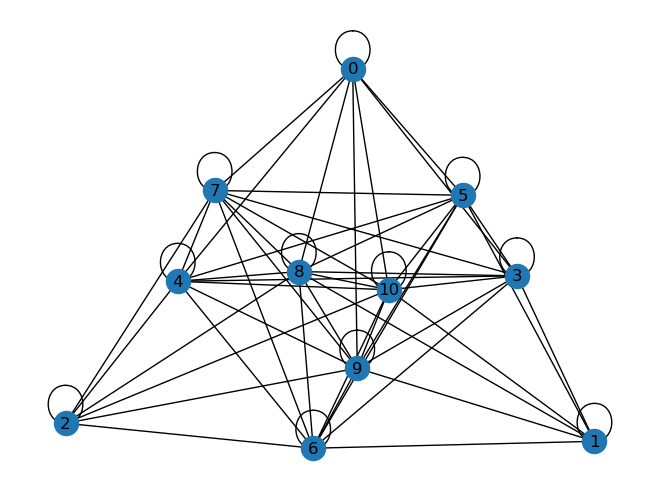

In [8]:
G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)


Let's define a QUBO model and then solve it via simulated annealing.

In [ ]:
model = dimod.BinaryQuadraticModel.from_qubo(Q, offset=cQ)

In [ ]:
from eqc_models.base import ConstrainedPolynomialModel, PolynomialModel
from eqc_models.solvers.qciclient import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver

n = Q.shape[0]

diag_idx = np.vstack([np.arange(n), np.arange(n)]).T
quad_idx = np.vstack(np.triu_indices(n, k=1)).T
all_indices = np.vstack([diag_idx, quad_idx])

lin_coeff = Q[np.arange(n), np.arange(n)]
quad_coeff = Q[np.triu_indices(n, k=1)]


# model = ConstrainedPolynomialModel()

Minimum Objective Value: 5
Best Solution Found: 00000000100


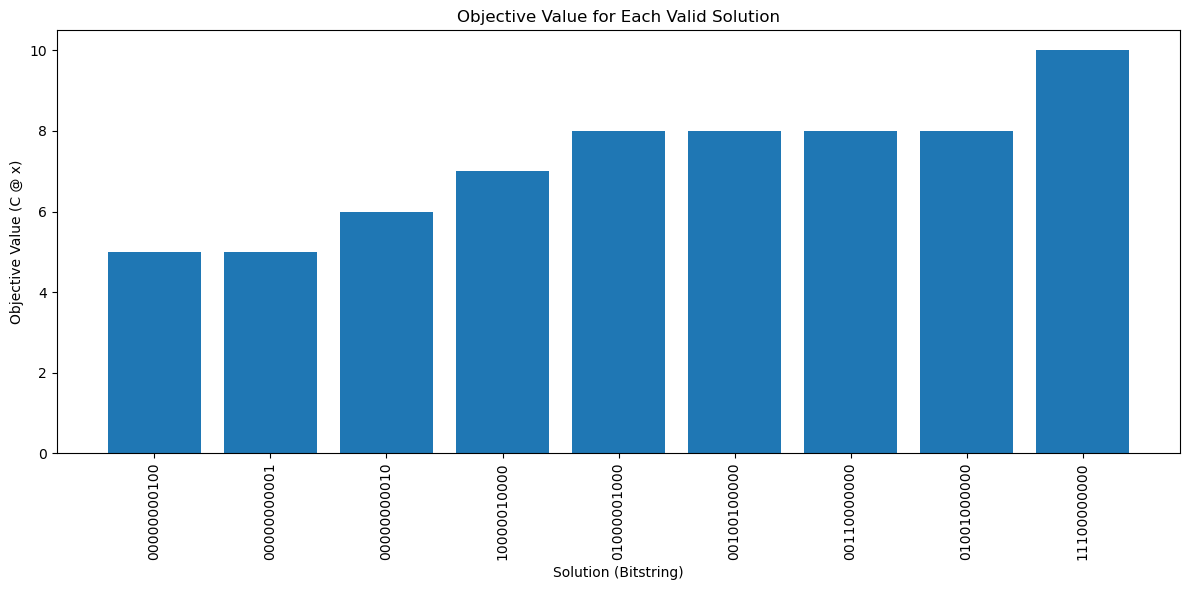

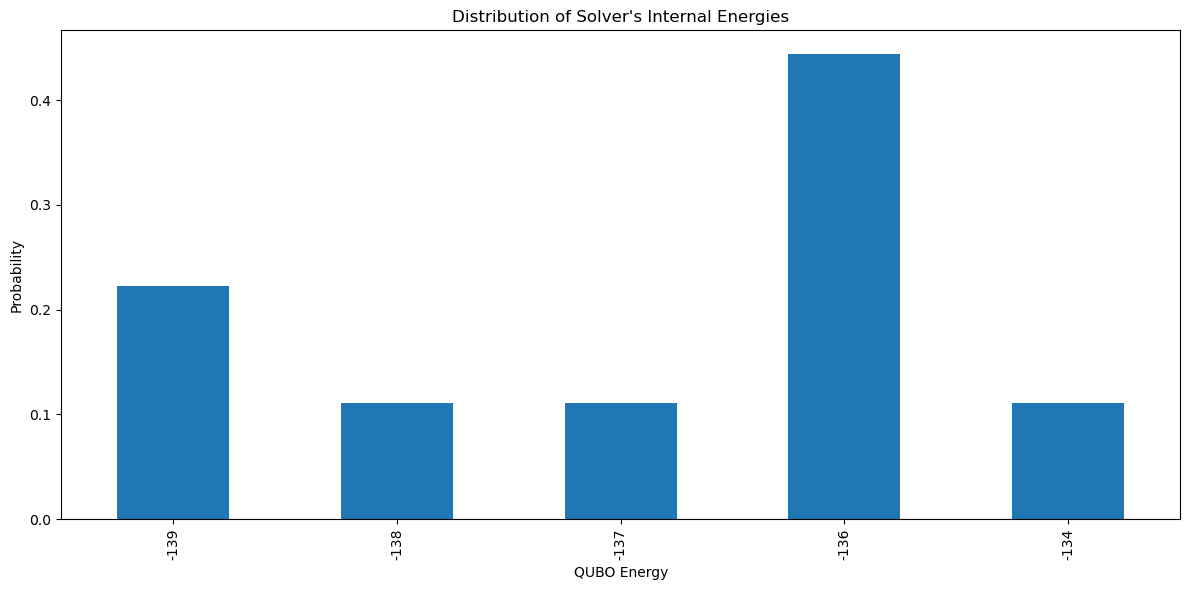

Minimum QUBO Energy: -139


In [65]:
def plot_objective_values(response, C, title="Solution Objective Values"):
    """
    Plots the true objective value for each unique solution returned by the QCI solver.

    This is more meaningful than plotting the QUBO "energy," as it shows the
    quality of each solution with respect to the original problem definition.

    Args:
        response (dict): The response object from the QCI solver.
        C (np.array): The original cost vector of the objective function.
        title (str): The title for the plot.
    """
    # Extract the list of unique solutions
    solutions = response["results"]["solutions"]
    if not solutions:
        print("No solutions found in the response.")
        return

    # Calculate the true objective value for each solution
    objective_values = [np.dot(C, s) for s in solutions]
    
    # Create string representations of the binary solutions for labels
    solution_strings = [''.join(map(str, s)) for s in solutions]

    # Find the minimum objective value and the corresponding best solution
    min_value = min(objective_values)
    best_solution_str = solution_strings[objective_values.index(min_value)]

    print(f"Minimum Objective Value: {min_value}")
    print(f"Best Solution Found: {best_solution_str}")

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(solution_strings, objective_values)
    plt.xlabel('Solution (Bitstring)')
    plt.ylabel('Objective Value (C @ x)')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_energy_distribution(response, title="QUBO Energy Distribution"):
    """
    Plots the distribution of the raw QUBO energies from the solver.

    This shows the probability of measuring each energy state and is useful
    for diagnosing the solver's performance on the underlying QUBO formulation.

    Args:
        response (dict): The response object from the QCI solver.
        title (str): The title for the plot.
    """
    # Extract energies from the response
    energies = response["results"].get("energies")
    
    if not energies:
        print("No energy data found in the response.")
        return

    # The total number of samples is the length of the energies list
    total_samples = len(energies)
    
    # Use collections.Counter to get the occurrences of each energy value.
    # We round the energies to group very similar floating-point values.
    energy_counts = Counter(round(e, 5) for e in energies)
    
    # Calculate the probability for each unique energy level
    energy_probabilities = {energy: count / total_samples for energy, count in energy_counts.items()}
        
    # Create a pandas DataFrame for easy plotting
    df = pd.DataFrame.from_dict(energy_probabilities, orient='index', columns=['Probability']).sort_index()

    # Create the plot
    df.plot(kind='bar', legend=None, figsize=(12, 6))
    plt.xlabel('QUBO Energy')
    plt.ylabel('Probability')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    print(f"Minimum QUBO Energy: {min(energies)}")


# --- Example Usage ---
# After you have run your solver and have the 'response' object:

# 1. Plot the true objective values for each solution
plot_objective_values(response, C, title="Objective Value for Each Valid Solution")

# 2. Plot the distribution of the internal QUBO energies
plot_energy_distribution(response, title="Distribution of Solver's Internal Energies")

Let's now solve this problem using Simulated Annealing

In [ ]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=1000)

In [ ]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

## Now let's solve this using Dirac-3!


Now we can play with the other parameters such as Annealing time, chain strength, and annealing schedule to improve the performance of D-Wave's Quantum Annealing.